In [21]:
import numpy as np
import pandas as pd
from scipy import integrate
from superlink.infiltration import GreenAmpt
from superlink.hydraulics import SuperLink
from superlink.simulation import Simulation
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('husl')

%matplotlib inline

# Run Green-Ampt

In [2]:
n = 10
i = np.linspace(0, 60 / 1000, n)     # Rainfall (m/hr)
Ks = 40 / 1000 * np.ones(n)          # Saturated hydraulic conductivity
theta_s = 0.370 * np.ones(n)         # Saturated soil moisture content
theta_r = 0.025 * np.ones(n)         # Wilting point soil moisture content
theta_i = 0.15 * np.ones(n)          # Initial soil moisture content
lambda_o = 0.474                     # Brooks corey parameter
psi_b = 50/1000                      # Brooks corey suction head
dt = 0.01                            # Time step (hrs)

In [3]:
psi_f = GreenAmpt.suction_head(theta_i, theta_s, theta_r, Ks, psi_b, lambda_o)

In [4]:
ga = GreenAmpt(psi_f, Ks, theta_s, theta_i)

In [5]:
i_sim = np.vstack([np.tile(i, 200).reshape(200, -1), np.zeros((200, n))])

In [6]:
F = []
f = []
d = []

# Continue running green-ampt
for i in i_sim:
    ga.step(dt, i)
    ga.d += (i - ga.f)
    ga.d[ga.d <= 0.] = 0
    f.append(np.copy(ga.f))
    F.append(np.copy(ga.F))
    d.append(np.copy(ga.d))

Text(0.5, 0, 'Time (hr)')

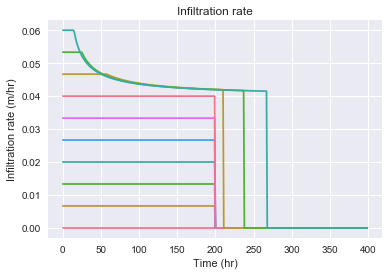

In [7]:
_ = plt.plot(np.vstack(f))
plt.title('Infiltration rate')
plt.ylabel('Infiltration rate (m/hr)')
plt.xlabel('Time (hr)')

Text(0.5, 0, 'Time (hr)')

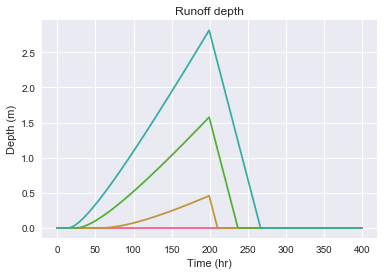

In [8]:
_ = plt.plot(np.vstack(d))
plt.title('Runoff depth')
plt.ylabel('Depth (m)')
plt.xlabel('Time (hr)')

In [9]:
runoff_rate = np.maximum(i_sim - np.vstack(f), 0)

Text(0.5, 0, 'Time (hr)')

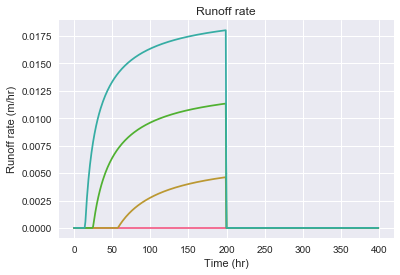

In [10]:
_ = plt.plot(runoff_rate)
plt.title('Runoff rate')
plt.ylabel('Runoff rate (m/hr)')
plt.xlabel('Time (hr)')

# Create superlinks and superjunctions representing hillslopes

In [11]:
superjunctions = pd.DataFrame()
superjunctions['name'] = np.arange(20)
superjunctions['id'] = np.arange(20)
superjunctions['z_inv'] = np.repeat([1,0], 10)
superjunctions['h_0'] = 1e-5
superjunctions['bc'] = np.repeat([True, False], 10)
superjunctions['storage'] = 'functional'
superjunctions['a'] = 0.0
superjunctions['b'] = 0.0
superjunctions['c'] = 1e5
superjunctions['max_depth'] = np.inf

In [12]:
superlinks = pd.DataFrame()
superlinks['name'] = np.arange(10)
superlinks['id'] = np.arange(10)
superlinks['sj_0'] = np.arange(10)
superlinks['sj_1'] = np.arange(10, 20)
superlinks['in_offset'] = 0.0
superlinks['out_offset'] = 0.1
superlinks['dx'] = 1000
superlinks['n'] = 0.035
superlinks['shape'] = 'wide'
superlinks['g1'] = 10
superlinks['g2'] = 100
superlinks['g3'] = 0
superlinks['g4'] = 0
superlinks['Q_0'] = 0
superlinks['h_0'] = 1e-5
superlinks['ctrl'] = False
superlinks['A_s'] = 100
superlinks['A_c'] = 0
superlinks['C'] = 0

# Run superlink model to compute overland flow

In [36]:
# Specify subdivisions
njunctions_fixed = 16

In [37]:
# Specify inflows
Q_j = pd.DataFrame(runoff_rate / 3600, index=np.arange(0, 36 * len(runoff_rate), 36))
Q_Ik = (1000 * 100 / (njunctions_fixed)
        * pd.DataFrame(np.repeat(Q_j.values,
                                 njunctions_fixed + 1).reshape(Q_j.shape[0], -1)))
Q_Ik.index = Q_j.index.astype(float)

In [38]:
# Create model
superlink = SuperLink(superlinks, superjunctions, njunctions_fixed=njunctions_fixed)

In [39]:
# Set flow at downstream nodes to 0
Q_Ik[superlink.end_nodes] = 0.0

In [40]:
# Set initial timestep
dt = 10

# Create simulation context manager
with Simulation(superlink, Q_Ik=Q_Ik, dt=dt,
                min_dt=1e-6, max_dt=60,
                min_rel_change=1e-10, max_rel_change=1e10) as simulation:
    # While simulation time has not expired...
    simulation.t_end = simulation.t_end
    for step in simulation.steps:
        if simulation.t >= simulation.t_end:
            break
        simulation.step(dt=dt)
        # Record internal depth and flow states
        simulation.record_state()
        # Print progress bar
        simulation.print_progress()

[==================================================] 100.0% [1.4 s]

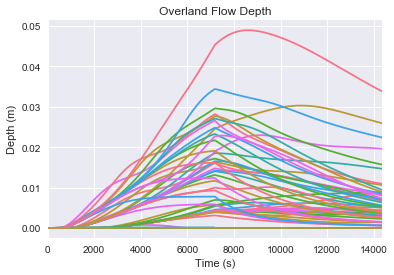

In [41]:
simulation.states._h_Ik.plot(legend=False)
plt.title('Overland Flow Depth')
plt.ylabel('Depth (m)')
_ = plt.xlabel('Time (s)')

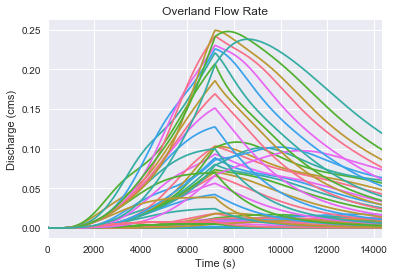

In [42]:
simulation.states._Q_ik.plot(legend=False)
plt.title('Overland Flow Rate')
plt.ylabel('Discharge (cms)')
_ = plt.xlabel('Time (s)')

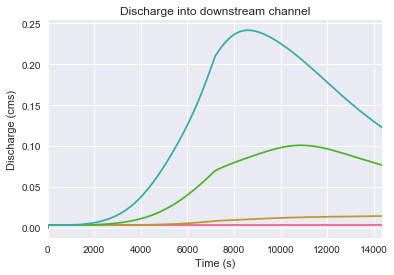

In [43]:
simulation.states._Q_dk.plot(legend=False)
plt.title('Discharge into downstream channel')
plt.ylabel('Discharge (cms)')
_ = plt.xlabel('Time (s)')